In [5]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor


import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import XGBRegressor

from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go

import hyperopt
from hyperopt import hp
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold

from IPython.display import HTML as html_print
from IPython.display import HTML
from IPython.display import display

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer

import warnings
warnings.filterwarnings('ignore')
def normalize(df):
    return (df - df.mean()) / (df.max() - df.min())

def highlight_max(s, col="orange"):
    '''
    Color the maximum value in column or row of the DataFrame into yellow.
    :input: serires object
    :return: colored object
    '''
    is_min = s == s.max()
    return ['background-color: {}'.format(col) if v else '' for v in is_min]
def highlight_min(s, col="yellow"):
    '''
    Color the maximum value in column or row of the DataFrame into yellow.
    :input: serires object
    :return: colored object
    '''
    is_min = s == s.min()
    return ['background-color: {}'.format(col) if v else '' for v in is_min]

In [23]:
# extracting data
data = pd.read_csv('shared_data/features.csv')
data.describe()

,Unnamed: 0,Unnamed: 0.1,venue_id,latitude,longitude,density,neighbors_entropy,competitiveness,area_popularity,transition_density,incoming_flow,transition quality,n_same_business_in_area,target_check_ins
count,277.00000,277.00000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.00000,277.000000,277.000000,277.000000
mean,138.00000,138.00000,45750.075812,40.737317,-73.919080,84.368231,5.850152,-0.075076,1561.718412,301.205776,479.65343,19.815884,0.122744,269.801444
std,80.10722,80.10722,24741.965122,0.079282,0.135762,101.946214,2.079991,0.090120,2647.804810,511.992560,834.76944,30.484708,0.465579,267.019269
min,0.00000,0.00000,162.000000,40.516800,-74.233310,1.000000,0.000000,-1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.000000
25%,69.00000,69.00000,26240.000000,40.700645,-73.997420,14.000000,4.125843,-0.100000,52.000000,11.000000,13.00000,1.000000,0.000000,110.000000
50%,138.00000,138.00000,48149.000000,40.736797,-73.957750,27.000000,5.665379,-0.051282,234.000000,49.000000,55.00000,4.000000,0.000000,194.000000
75%,207.00000,207.00000,66822.000000,40.777530,-73.857170,141.000000,7.598930,-0.021739,1783.000000,347.000000,582.00000,30.000000,0.000000,331.000000
max,276.00000,276.00000,85297.000000,40.959766,-73.516380,396.000000,10.556083,0.000000,13152.000000,2651.000000,4209.00000,139.000000,3.000000,2412.000000


In [24]:
X_all = data[['density','neighbors_entropy','competitiveness','area_popularity','transition_density','incoming_flow','transition quality']]
X_geografical = data[['density','neighbors_entropy','competitiveness', 'n_same_business_in_area']]
X_mobility = data[['area_popularity','transition_density','incoming_flow','transition quality']]
y = data['target_check_ins']

#Normalizing works not so good for that task so it was decidet not to use it
# X = normalize(X)
# X_geografical = normalize(X_geografical)
# X_mobility = normalize(X_mobility)
# y = normalize(y)

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=2018)

In [25]:
# sklearn grids
grid_SGD = {'alpha':hp.uniform('alpha', 0, 0.3),
            'penalty': hp.choice('penalty',['l2', 'l1', 'elasticnet'])}
grid_DecisionTreeRegressor = {
                              'random_state':hp.quniform('random_state', 1, 20, q=1),
                              'max_depth': hp.quniform('max_depth', 1, 30, q=1)
                                }
grid_Lasso = {  'alpha':hp.uniform('alpha', 0, 2),
                'random_state':hp.quniform('random_state', 1, 20, q=1),
                'max_iter': hp.quniform('max_iter', 1, 20000, q=1)}
                                

grid_Elastic = {'alpha':hp.uniform('alpha', 0, 2),
                'random_state':hp.quniform('random_state', 1, 20, q=1),
                'max_iter': hp.quniform('max_iter', 1, 20000, q=1)
                                }

grid_Ridge =  { 'alpha':hp.uniform('alpha', 0, 3),
                'random_state':hp.quniform('random_state', 1, 20, q=1),
                'solver':hp.choice('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
                                }

grids = [grid_SGD,grid_DecisionTreeRegressor,grid_Lasso,grid_Elastic,grid_Ridge]

In [14]:
#defining metric ndcg
def ndcg(y_real, y_pred, p=10):
    to_test = pd.DataFrame({'real':y_real, 'predicted':y_pred})
    to_test = to_test.sort_values(by = 'real', ascending=False)
    to_test['real_ratings'] = [abs(x) for x in range(-len(to_test),0)]
    to_test = to_test.sort_values(by = 'predicted', ascending=False)
    rr = list(to_test.head(p).real_ratings)
    dcg = 0
    idcg = 0
    for i in range(len(rr)):
        dcg+=rr[i]/np.log2(i+2)
        idcg+=(len(to_test)-i)/np.log2(i+2)
    return dcg/idcg

# making custom scorer out of ndcg for cv
ndcg_scorer = make_scorer(ndcg)

In [15]:
# Defining functions for alghorithms for futher TPE hyperparametres optimization
class SGD_reg:

    def __init__(self, X, y):
        self.X = X
        self.y = y

    # Calculate cross validation score (default is10-fold CV)
    def __call__(self, X, cv=10):
        # Make the SVM classifire with  the specific 'C' and 'degree'
        reg = SGDRegressor(alpha = X['alpha'], penalty=X['penalty'])
        # Compute the CV score
        accuracy = cross_val_score(reg, self.X, self.y, scoring=ndcg_scorer, cv=KFold(n_splits=cv, shuffle=False, random_state=2))
        accuracy = np.mean(accuracy)
        #print(accuracy, X)
        return 1. - accuracy    # for minimization
    
    
class DT_reg:

    def __init__(self, X, y):
        self.X = X
        self.y = y

    # Calculate cross validation score (default is10-fold CV)
    def __call__(self, X, cv=10):
        # Make the SVM classifire with  the specific 'C' and 'degree'
        reg = DecisionTreeRegressor(random_state=int(X['random_state']), max_depth = X['max_depth'])
        # Compute the CV score
        accuracy = cross_val_score(reg, self.X, self.y, scoring=ndcg_scorer, cv=KFold(n_splits=cv, shuffle=False, random_state=2))
        accuracy = np.mean(accuracy)
        #print(accuracy, X)
        return 1. - accuracy    # for minimization

    
    
class Lasso_reg:

    def __init__(self, X, y):
        self.X = X
        self.y = y

    # Calculate cross validation score (default is10-fold CV)
    def __call__(self, X, cv=10):
        # Make the SVM classifire with  the specific 'C' and 'degree'
        reg = Lasso(alpha = X['alpha'], random_state=int(X['random_state']), max_iter=X['max_iter'])
        # Compute the CV score
        accuracy = cross_val_score(reg, self.X, self.y, scoring=ndcg_scorer, cv=KFold(n_splits=cv, shuffle=False, random_state=2))
        accuracy = np.mean(accuracy)
        #print(accuracy, X)
        return 1. - accuracy    # for minimization



class Elastic_reg:

    def __init__(self, X, y):
        self.X = X
        self.y = y

    # Calculate cross validation score (default is10-fold CV)
    def __call__(self, X, cv=10):
        # Make the SVM classifire with  the specific 'C' and 'degree'
        reg = ElasticNet(alpha = X['alpha'], random_state=int(X['random_state']), max_iter=X['max_iter'])
        # Compute the CV score
        accuracy = cross_val_score(reg, self.X, self.y, scoring=ndcg_scorer, cv=KFold(n_splits=cv, shuffle=False, random_state=2))
        accuracy = np.mean(accuracy)
        #print(accuracy, X)
        return 1. - accuracy    # for minimization
    
    
class Ridge_reg:

    def __init__(self, X, y):
        self.X = X
        self.y = y

    # Calculate cross validation score (default is10-fold CV)
    def __call__(self, X, cv=10):
        # Make the SVM classifire with  the specific 'C' and 'degree'
        reg = Ridge(random_state=int(X['random_state']), solver = X['solver'], alpha = X['alpha'])
        # Compute the CV score
        accuracy = cross_val_score(reg, self.X, self.y, scoring=ndcg_scorer, cv=KFold(n_splits=cv, shuffle=False, random_state=2))
        accuracy = np.mean(accuracy)
        #print(accuracy, X)
        return 1. - accuracy    # for minimization
    
    
functions = [SGD_reg,DT_reg,Lasso_reg,Elastic_reg,Ridge_reg]

### Parametres tuning

In [16]:
# tuned parametres 


regg_n = ['SGDRegressor', 'DecisionTreeRegressor', 'ElasticNet', 'Lasso', 'Ridge']

regressors = [
               SGDRegressor(alpha= 0.05833538843265764, penalty='elasticnet'), 
               DecisionTreeRegressor(max_depth= 5.0, random_state= 1),
               ElasticNet(alpha=  0.009508270512716577, max_iter =  17000, random_state = 14), 
               Lasso(alpha =  0.714115650589215, max_iter = 1300, random_state =  3),
               Ridge(random_state =  4, solver = 'sparse_cg', alpha =  2.9020733918824244)
]

for func, grid, reg, name in zip(functions, grids, regressors, regg_n):
    # Objective function
    f = func(X_train, y_train)
    trials = hyperopt.Trials()
    # Run TPE
    best = hyperopt.fmin(f, grid, algo=hyperopt.tpe.suggest, max_evals=25, trials=trials, verbose=1)
    print(name)
    print("best estimate parameters", best)

SGDRegressor
best estimate parameters {'alpha': 0.07989027241023866, 'penalty': 0}
DecisionTreeRegressor
best estimate parameters {'max_depth': 5.0, 'random_state': 2.0}
ElasticNet
best estimate parameters {'alpha': 0.06071453310347545, 'max_iter': 22.0, 'random_state': 8.0}
Lasso
best estimate parameters {'alpha': 1.3823151889029495, 'max_iter': 119.0, 'random_state': 6.0}
Ridge
best estimate parameters {'alpha': 2.8689495703391605, 'random_state': 2.0, 'solver': 4}


In [21]:
accuracy_m = []
accuracy_s = []
regressors = [
               SGDRegressor(alpha= 0.05833538843265764, penalty='elasticnet'), 
               DecisionTreeRegressor(max_depth= 5.0, random_state= 1),
               ElasticNet(alpha=  0.009508270512716577, max_iter =  17000, random_state = 14), 
               Lasso(alpha =  0.714115650589215, max_iter = 1300, random_state =  3),
               Ridge(random_state =  4, solver = 'sparse_cg', alpha =  2.9020733918824244)
]
for regg in regressors: 
    accuracy = cross_val_score(regg, X_train, y_train, scoring=ndcg_scorer, cv=KFold(n_splits=5, shuffle=True,  random_state=2))
    accuracy_mean = np.mean(accuracy)
    accuracy_std = np.std(accuracy)
    accuracy_m.append(accuracy_mean)
    accuracy_s.append(accuracy_std)
    print(regg)
    print(accuracy_mean)
    print(accuracy_std)

SGDRegressor(alpha=0.05833538843265764, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5, n_iter=None, penalty='elasticnet',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
0.5898927050537618
0.2504895652943474
DecisionTreeRegressor(criterion='mse', max_depth=5.0, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
0.8249987110657402
0.06366590877512945
ElasticNet(alpha=0.009508270512716577, copy_X=True, fit_intercept=True,
      l1_ratio=0.5, max_iter=17000, normalize=False, positive=False,
      precompute=False, random_state=14, selection='cyclic', tol=0.0001,
      warm_start=False)
0.831875908804635
0.06292461289422473
Lasso(alpha=0.

In [22]:
print(  )
display(html_print("<p style='font-weight: bold; color:black; font-size:200%; font-family:verdana;text-align:center;'> Ranking metrics NDCG@10 without Normalization</p>"))
print() 
    
res = pd.DataFrame({'cross_val_ndcg_mean':accuracy_m, 'cross_val_ndcg_std':accuracy_s}, index = regg_n)
res = res.sort_values('cross_val_ndcg_mean', ascending = False).style.apply(lambda x: highlight_max(x, col="orange"), axis=0)

res

,cross_val_ndcg_mean,cross_val_ndcg_std
Ridge,0.842278,0.0441137
Lasso,0.832357,0.0648106
ElasticNet,0.831876,0.0629246
DecisionTreeRegressor,0.824999,0.0636659
SGDRegressor,0.589893,0.25049


In [20]:
x = regg_n
y = accuracy_m
z = accuracy_s

datap = [
  go.Histogram(
    histfunc = "avg",
    y = y,
    x = x,
    name = "mean")
]

py.iplot(datap, filename='binning function')

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

### XGBoost lib

In [61]:
data_dmatrix = xgb.DMatrix(X_train,y_train)
XGBRegressor = xgb.XGBRegressor(random_state=1, objective = 'reg:linear')
# CV_SSS = ShuffleSplit(n_splits=5, test_size=0.2, random_state=2)

xgb_param_grid = {
                  'max_depth': [x for x in range(2,10)],
                  'learning_rate': [x*0.001 for x in range(0,100)],
                  'n_estimators': [x*10 for x in range(5,15)],
                  'reg_alpha': [x*0.05 for x in range(3,15)],
                  'reg_lambda': [x*0.05 for x in range(3,14)],
                  'min_child_weight':[x for x in range(0,10)],
                  'subsample':[x*0.05 for x in range(2,10)],
                  'colsample_bytree':[x*0.05 for x in range(6,10)]
                 }

random_grid_XGB_CV = RandomizedSearchCV(XGBRegressor,
                                        xgb_param_grid,
                                        scoring = ndcg_scorer,
                                        cv = KFold(n_splits=5, shuffle=True, random_state=2),
                                        n_iter = 400
                                        )
random_grid_XGB_CV.fit(X_train, y_train)
print(random_grid_XGB_CV.best_score_)
print(random_grid_XGB_CV.best_params_)

0.854148605497026
{'subsample': 0.15000000000000002, 'reg_lambda': 0.4, 'reg_alpha': 0.5, 'n_estimators': 80, 'min_child_weight': 8, 'max_depth': 9, 'learning_rate': 0.084, 'colsample_bytree': 0.30000000000000004}


In [98]:
XGB_Regressor = random_grid_XGB_CV.best_estimator_

scores = cross_val_score(XGB_Regressor, X_train, y_train, scoring=ndcg_scorer, cv=KFold(n_splits=5, shuffle=True, random_state=2))
print('XGBoost score without norming', scores.mean(), scores.std())
XGB_Regressor.fit(X_train, y_train)
regg_n = ['XGBoost','SGDRegressor', 'DecisionTreeRegressor', 'ElasticNet', 'Lasso', 'Ridge']
features_importamce = [XGB_Regressor.feature_importances_]
mean_ndcg = [scores.mean()]
std_ndcg = [scores.std()]


for reggg , name in zip(regressors,regg_n[1:]):
    rig = reggg
    scores = cross_val_score(rig, X_train, y_train, scoring=ndcg_scorer, cv=KFold(n_splits=5, shuffle=True, random_state=2))
    print('Score without norming', scores.mean(), scores.std())
    rig.fit(X_train, y_train)
    if name!='DecisionTreeRegressor':
        features_importamce.append(rig.coef_)
    else:
        features_importamce.append(rig.feature_importances_)
    std_ndcg.append(scores.std())
    mean_ndcg.append(scores.mean())

XGBoost score without norming 0.8537239761746639 0.08412018081169485
Score without norming 0.5601706572025296 0.1773676379706743
Score without norming 0.8249987110657402 0.06366590877512945
Score without norming 0.831875908804635 0.06292461289422473
Score without norming 0.8323568277136488 0.06481057315424389
Score without norming 0.8422784182082801 0.044113714227302404


In [99]:

N = 7
x = ['density','neighbors_entropy','competitiveness','area_popularity','transition_density','incoming_flow','transition quality']

# Create traces
trace1 = go.Scatter(
    x = x,
    y = features_importamce[0],
    mode = 'lines+markers',
    name = 'XGBoost Regressor'
)
trace2 = go.Scatter(
    x = x,
    y = features_importamce[1],
    mode = 'lines+markers',
    name = 'SGDRegressor'
)
trace3 = go.Scatter(
    x = x,
    y = features_importamce[2],
    mode = 'lines+markers',
    name = 'DecisionTreeRegressor'
)
trace4 = go.Scatter(
    x = x,
    y = features_importamce[3],
    mode = 'lines+markers',
    name = 'ElasticNet'
)
trace5 = go.Scatter(
    x = x,
    y = features_importamce[4],
    mode = 'lines+markers',
    name = 'Lasso'
)
trace6 = go.Scatter(
    x = x,
    y = features_importamce[5],
    mode = 'lines+markers',
    name = 'Ridge'
)
dataq = [trace1, trace3, trace5, trace6]

# # Edit the layout
# layout = dict(title = 'Features importance for regressors',
#               xaxis = dict(title = 'features'),
#               yaxis = dict(title = 'coefs'),
#               )
# fig = dict(data=dataq, layout=layout)
# py.iplot(fig, filename='line-mode')

In [197]:

layout = dict(title = 'Features importance for regressors',
              xaxis = dict(title = 'features'),
              yaxis = dict(title = 'coefs'),
              )



fig = tools.make_subplots(rows=2, cols=3, subplot_titles=('XGBoost Regressor', 'SGDRegressor',
                                                          'DecisionTreeRegressor', 'ElasticNet','Lasso','Ridge'))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=600, width=1100, title='Feature importance for each model')

py.iplot(fig, filename='make-subplots-multiple-with-titles')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



TypeError: Index must be int, not <class 'str'>

In [101]:
# Adding Baseline random model to compare performance
def baseline_model(y_test):
    return np.random.choice(len(y_test), len(y_test), replace=False)
scores = []
for i in range(10):
    preds = baseline_model(X_test)
    scores.append(ndcg(y_real=y_test,y_pred=preds))
    
mean_ndcg.append(np.array(scores).mean())
std_ndcg.append(np.array(scores).std())
regg_n.append('Baseline')

In [103]:
x = regg_n
y = mean_ndcg
z = std_ndcg

datap = [
  go.Histogram(
    histfunc = "avg",
    y = y,
    x = x)
]

layout = dict(title = 'Comparing performance of regression models',
              xaxis = dict(title = 'Alghorithms'),
              yaxis = dict(title = 'NDCG'),
              )
fig = dict(data=datap, layout=layout)

py.iplot(fig, filename='histogram')

In [191]:
print(  )
display(html_print("<p style='font-weight: bold; color:black; font-size:200%; font-family:verdana;text-align:center;'> Ranking metrics NDCG@10 without Normalization</p>"))
print() 
    
res = pd.DataFrame({'cross_val_ndcg_mean':mean_ndcg, 'cross_val_ndcg_std':std_ndcg}, index = regg_n)
res = res.sort_values('cross_val_ndcg_mean', ascending = False).style.apply(lambda x: highlight_max(x, col="orange"), axis=0)

res

,cross_val_ndcg_mean,cross_val_ndcg_std
XGBoost,0.853724,0.0841202
Ridge,0.842278,0.0441137
Lasso,0.832357,0.0648106
ElasticNet,0.831876,0.0629246
DecisionTreeRegressor,0.824999,0.0636659
Baseline,0.602466,0.116668
SGDRegressor,0.560171,0.177368


### Try to build model based only on geographic features

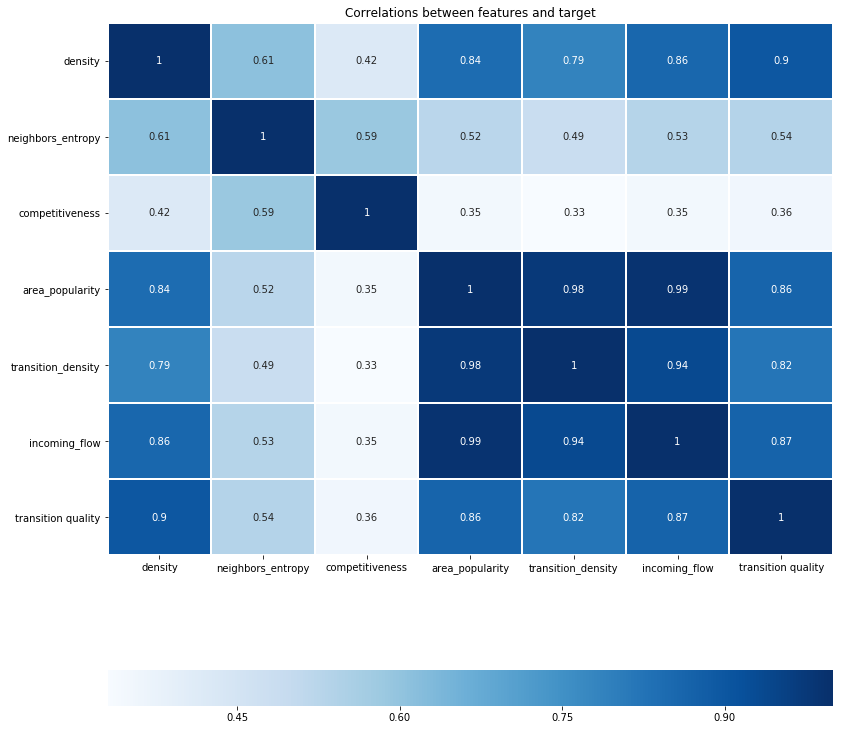

In [127]:
import numpy as np
np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13,14]
corr = X_all.corr()
sns.heatmap(corr, annot=True, linewidths=1, cbar_kws={"orientation": "horizontal"}, cmap="Blues")
plt.title('Correlations between features and target')
plt.show()

In [198]:
import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('', '')
data = Data([
    Bar(
        x=['Sivaranjani S', 'Vijayalakshmi C', 'Rajeshwari S', 'Shanthi Priscilla', 'Pandiyaraj G', 'Kamatchi S', 'MohanaPriya', 'Madhumitha G', 'Franklin Alphones Raj J', 'Akfaris Almaas', 'Biswajit Champati', 'Priya R', 'Rekha Rajasekaran', 'Sarath Kumar B', 'Jegan L', 'Karthick A', 'Mahalakshmi S', 'Ragunathan V', 'Anu S', 'Ramkumar KS', 'Uthra R'],
        y=[1640, 1394, 1390, 1313, 2166, 1521, 1078, 1543, 780, 1202, 1505, 2028, 2032, 1769, 1238, 1491, 1477, 1329, 2038, 1339, 1458],
        text=['Scuti', 'Scuti', 'Cygni', 'Scorpii', 'Scuti', 'Pollux', 'Scorpii', 'Pollux', 'Scuti', 'Pollux', 'Scorpii', 'Scorpii', 'Scuti', 'Cygni', 'Scorpii', 'Scuti', 'Scuti', 'Pollux', 'Scuti', 'Pollux', 'Pollux']
    )
])

layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig = Figure(data=data, layout=layout)

plot_url = py.plot(fig, filename='transparent-background')

# Making files for plotting in kepler

In [140]:
X = data[['venue_id', 'latitude', 'longitude', 'density',
       'neighbors_entropy', 'competitiveness', 'area_popularity',
       'transition_density', 'incoming_flow', 'transition quality',
       'n_same_business_in_area']]

In [146]:
y = data['target_check_ins']

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

In [185]:
train = pd.concat([X_train, y_train], axis=1)
train.to_csv('data/train_to_plot.csv', index = None)

In [186]:
test = pd.concat([X_test, y_test], axis=1)
test.to_csv('data/test_to_plot.csv', index = None)

In [162]:
test = test[['density','neighbors_entropy','competitiveness','area_popularity','transition_density','incoming_flow','transition quality']]
train = train[['density','neighbors_entropy','competitiveness','area_popularity','transition_density','incoming_flow','transition quality']]


In [ ]:
#defining metric ndcg
def ndcg(y_real, y_pred, p=10):
    to_test = pd.DataFrame({'real':y_real, 'predicted':y_pred})
    to_test = to_test.sort_values(by = 'real', ascending=False)
    to_test['real_ratings'] = [abs(x) for x in range(-len(to_test),0)]
    to_test = to_test.sort_values(by = 'predicted', ascending=False)
    rr = list(to_test.head(p).real_ratings)
    dcg = 0
    idcg = 0
    for i in range(len(rr)):
        dcg+=rr[i]/np.log2(i+2)
        idcg+=(len(to_test)-i)/np.log2(i+2)
    return dcg/idcg

# making custom scorer out of ndcg for cv
ndcg_scorer = make_scorer(ndcg)

In [161]:
best_test = test.sort_values(by = 'target_check_ins', ascending=False)
best_test = best_test.head(10)
best_test.to_csv('data/top10_test_plot.csv', index = None)

In [174]:
res = regressors[4].predict(test)

In [187]:
predict = pd.DataFrame({'real_ratings':y_test, 'predicted':res, 'venue_id':test['venue_id'], 'latitude':test['latitude'], 'longitude':test['longitude']}, index=y_test.index)

In [188]:
predicted_top_10 = predict.sort_values('predicted', ascending=False).head(10)

In [189]:
predicted_top_10.to_csv('data/predicted_top_10_plot.csv', index = None)

In [190]:
predicted_top_10

,latitude,longitude,predicted,real_ratings,venue_id
28,40.754240,-73.975870,781.694767,676.0,29262.0
140,40.740665,-73.987236,718.415601,1452.0,65714.0
252,40.755974,-73.991760,708.275208,142.0,82679.0
131,40.754980,-73.985790,681.342107,1389.0,62165.0
191,40.706917,-74.007256,579.300174,556.0,29989.0
157,40.760715,-73.976180,490.430582,292.0,68560.0
84,40.733063,-73.989975,489.644878,1252.0,47416.0
33,40.737335,-74.028730,473.688753,519.0,5046.0
160,40.749950,-73.982190,452.908717,420.0,24937.0
10,40.736797,-73.995940,441.147185,722.0,83878.0
